# Support Vector Machines (SVMs)

Author: Jacob McCabe

## Overview

This notebook will take a look at Support Vector Machines for the purpose of classification. The main ideas covered will include:

1. The main idea behind SVMs
2. Primal Problem
3. Dual Problem
4. Kernel Functions
5. Multiclass SVMs
6. Example using `SVC` from `scikit-learn`

## What is a SVM?

Support Vector Machines are a category of non-probabilistic, supervised learning algorithms for binary classification. They work by fitting a hyperplane between classes, and are trained by finding the hyperplane that maximizes the margin. Margin is the distance between the decision boundary and closest data point. Those points that are closest to the decision boundary and thus define the margin are referred to as support vectors.

<img src="images\svm_visualization.png" height='50%' width='50%'>


One of the important properties of this class of algorithms is that they are equivalent to solving a convex optimization problem, so any local solution is also a global optimum. When it comes to solving for the optimum, there are a few different flavors of SVMs.

If the classes are linearly seperable, we call this a **hard margin**. This is the case where all of class 0 falls on one side of the hyperplane and all of class 1 is on the other side. If the classes are not linearly seperable, it is a **soft margin**. In this case there are points in a class that fall on the wrong side of the hyperplane and a hyperparameter $C$ is needed to penalize the model based on how far over the boundary a point is. The soft margin problem also requires slack variables, $\xi$. These are scalar quantities representing how much a specific point has intruded into the margin. 

Within the hard and soft margin problems, there are two types of problems to consider: primal and dual.

## Primal Problems

The primal problem, the primal problem is more computationally efficient when the dimension of the data is significantly less than the number of observations. The objective function for the primal problem looks like this:

$\text{argmin}_{w,b,\xi} \frac{1}{2}||w||^2 + C\sum^{N}_{i=1}\xi_{i}$    
subject to $y_{i}(w^T\phi(x_i)+b) \ge 1-\xi \forall i\in[1,N]$ and $\xi_{i}\ge 0 \forall i\in [1,N]$.

Here, $C > 0$ is a hyperparameter defined in the soft margin problem. As $C$ nears infinity, the model behaves more like a hard margin problem. With regards to $\xi$, if all $\xi_{i} = 0$, it is a hard margin problem. Only if there exists some $\xi_{i} > 0$ is it a soft margin. $N$ is the number of data points in the training set and $\phi$ is a fixed feature-space transformation that increases the dimensionality of $x$.

## Dual Problems

Unlike the primal problem, the dual problem is more efficient when the number of observations is significantly less than the dimension of the data. This is the case where SVMs stand out most from other algorithms. There is an important bit of notation to be aware of here: $\alpha_{i}$ is an index into the vector $\alpha$ and $y_{(i)}$ is the $i$ index into the dataset. The objective function for the dual problem looks like:

$\text{argmax}_{\alpha} \sum^{N}_{i=1}\alpha_{i} - \frac{1}{2}\sum^{N}_{i=1}\sum^{N}_{j=1}\alpha_{i}\alpha_{j}y_{(i)}y_{(j)}\frac{\phi(x_{(i)})^{T}\phi(x_{(j)})}{K(x_{(i)},x_{(j)})}$    
subject to $0 \le \alpha_{i}\le C \forall i\in[1,N]$ and $\sum^{N}_{i=1}\alpha_{i}y_{(i)} = 0$.

Here we are maximizing each $\alpha_{i}$ individually as if its a set of $N$ scalars, not maximizing $||\alpha||$. It's worth noting that unlike in the primal problem, there is no $\xi$ but $C$ still shows up in the constraints. $K$ is a kernel function that we will talk about in the next section. Once we have our maximized $\alpha$, we are able to solve for $w$ and $b$.

$w = \sum^{N}_{i=1}\alpha_{i}y_{(i)}x_{(i)}$    
$b = y_{(i)} - w^{T}x_{(i)}$

In the dual problem, $\alpha_{i}>0$ if and only if $x_{(i)}$ is on the margin (i.e. a support vector). In general, you will find that $\alpha$ is sparse since there are typically only a few support vectors. Also, while $w$ and $b$ are unique (convex optimization), $\alpha$ is not guaranteed to be unique.

A key names:
- **Margin Support Vectors**: $\alpha_{i}>0$ and $\xi_{i}=0$
- **Non-Margin Support Vectors**: $\alpha_{i}>0$ and $\xi_{i}>0$
- **Non-Support Vectors**: $\alpha_{i}=0$ and $\xi_{i}=0$


## Kernel Functions

The purpose of a kernel function is to take the training data and project it into higher dimensional space, typically for the purpose of making a non-linear decision boundary. A few of the flavors include:

- **Linear Kernel**: Used for a linear boundary.    
$K(x,z) = x^(T)z$

- **Polynomial Kernel**: Used for creading a $d$-order polynomial expansion.    
$K(x,z) = (x^{T}z + 1)^{d}$, where $d$ is a hyperparameter.

- **Gaussian Radial Basis Function Kernel (RBF)**: Used for mapping points into an infinite number of dimensions.    
$K(x,z) = exp\{\frac{-||x-z||^{2}_{2}}{2\sigma^{2}} \}$, where $\sigma$ is a hyperparameter.

## Multiclass SVMs for C classes
Although I said that SVMs are binary classifiers, there are ways to make it work for multiple classes.
- **One vs. Rest**: Train $C$ binary SVMs where each one is class $i$ versus all other classes. The drawbacks of this are that you have to train $C$ models on all $N$ data points, which is computationally expensive, and the classes are highly imbalanced.

- **One vs. One**: Train $\frac{C(C-1)}{2}$ binary SVMs, i.e. every possible pairing of classes. Classify test points based on which class has the majority. The drawbacks of this are that it is a lot of classifiers to train, making it even more inefficient. Also, it requires a decision on how to handle ties 

## References

- [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
- [Image](https://datascience.stackexchange.com/questions/43180/maximize-the-margin-formula-in-support-vector-machines-algorithm)
- S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology.


## Example using `SVC` from `scikit-learn`

#### Imports



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading Data

We will be using the [Bank Marketing Data](https://archive.ics.uci.edu/dataset/222/bank+marketing) [Moro et al., 2011] 
which can be found on the UC Irvine Machine Learning Repository. 



In [2]:
data = pd.read_csv("./data/bank_full.csv",sep=";",header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
objects = data.select_dtypes(include=["object"]).copy()
objects.columns


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')

In [4]:
for idx, lab in enumerate(objects):
    data[lab] = data[lab].astype("category")
    data[lab] = data[lab].cat.codes

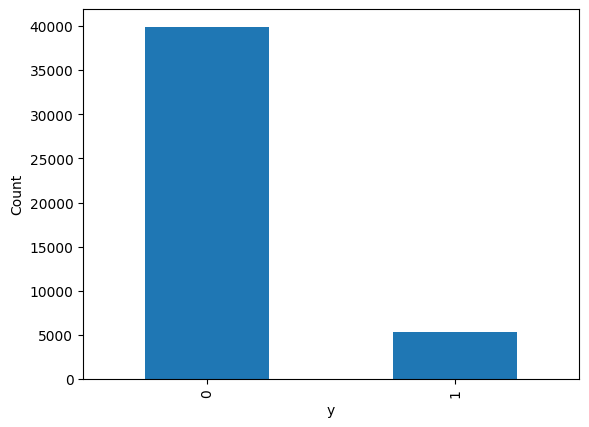

In [5]:
features = data.drop(["y"], axis=1)
target = data["y"].copy()

target.groupby(target).count().plot.bar(ylabel='Count')

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1)

Let's create a simple `Pipeline` that will scale the data and fit a standard `SVC`. The default parameters are $C=1.0$, and the RBF kernel with the hyperparameter `1/(n_features * X.var())`.

In [6]:
pipe_steps = [("scaler", StandardScaler()), ("rbf_svm", SVC())]
basic_pipe = Pipeline(pipe_steps)
basic_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rbf_svm', SVC())])

In [7]:
training_score = basic_pipe.score(X_train, y_train)
test_score = basic_pipe.score(X_test, y_test)
print(f"Training Score: {round(training_score, 3)}")
print(f"Test Score: {round(test_score, 3)}")

Training Score: 0.906
Test Score: 0.9


This is a pretty good classification for a simple model. Let's try tuning the parameter - modifying the regularization parameter $C$ and kernel function.

In [8]:
params = {
    "rbf_svm__C" : [0.1,1,10,100]
}

tune_C = RandomizedSearchCV(basic_pipe, param_distributions=params, random_state=10)

## Uncomment to run the random search, however it takes quite a bit of time to run.
#tune_C.fit(X_train, y_train)
#tune_pipe = tune_C.best_estimator_
#tune_C.best_params_
#C=10

In [9]:
pipe_steps = [("scaler", StandardScaler()), ("rbf_svm", SVC(C=10))]
basic_pipe = Pipeline(pipe_steps)
basic_pipe.fit(X_train, y_train)

training_score = basic_pipe.score(X_train, y_train)
test_score = basic_pipe.score(X_test, y_test)
print(f"Training Score: {round(training_score, 3)}")
print(f"Test Score: {round(test_score, 3)}")

Training Score: 0.925
Test Score: 0.903


As we can see, there is hardly a change in accuracy between models.